# Annual Sea Level Rankings

```{glue:figure} SL_rankings
:align: center
```
In this notebook, we'll be creating a [table](SL_rankings_results) and a time series [plot](SL_rankings_timeseries) of sea level rankings at Malakal from 1993-2024. Looking at extreme sea levels by ranking our top events helps us quickly put high and low water levels into historical context with relatively little coding effort. 

## Setup

As with previous sections, we first need to import the necessary libraries, and establish our input/output directories. Note that this notebook is also largely a repeat of the [anomaly](notebooks/regional_and_local/SL_anomaly_annual.ipynb) notebook. 

In [17]:
# import necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
from pathlib import Path
import pandas as pd
import os
import os.path as op
import sys

# data retrieval libraries
import requests
from urllib.request import urlretrieve #used for downloading files
import json
import copernicusmarine

# data processing libraries
from scipy import stats
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from myst_nb import glue #used for figure numbering when exporting to LaTeX

sys.path.append("../../../functions")
from data_downloaders import download_oni_index
from sea_level_func import detect_enso_events



Now we'll set up our input and output directories.

In [18]:
data_base_dir = Path('../../../data')
path_figs = "../../../matrix_cc/figures"
data_dir = Path(data_base_dir,'sea_level')


#CHANGE THIS TO YOUR PATH!!
# output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/output')  # EDIT THIS TO YOUR PATH
# output_dir = Path('/Users/laurac/Library/Mobile Documents/com~apple~CloudDocs/Projects/CC_indicators/CC_indicators/data/')  # EDIT THIS TO YOUR PATH
output_dir = Path('/Users/jfiedler/Projects/CC_indicators/output/')  # EDIT THIS TO YOUR PATH

# Create the output directory if it does not exist
output_dir.mkdir(exist_ok=True)
data_dir.mkdir(exist_ok=True)


# Also let's just make our figure sizes the same:
plt.rcParams['figure.figsize'] = [10, 4]  # Set a default figure size for the notebook

##  Retrieve the Tide Station(s) Data Set(s)

Next, we'll access data from the UHSLC. The Malakala tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset. We will also import the datums for this location. 

In [19]:
uhslc_id = 7
# download the hourly data
fname = f'h{uhslc_id:03}.nc' # h for hourly, d for daily

url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/" 

path = os.path.join(data_dir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 

rsl = xr.open_dataset(data_dir / fname)

# remove the trailing zero from record_id. This zero is added to the record_id to make it unique if the station has multiple entries
rsl['record_id'] =(rsl['record_id']/10).astype(int)

# change station_name to string
for col in ['station_name', 'station_country']:
    rsl[col] = rsl[col].astype(str)
rsl

<xarray.Dataset> Size: 6MB
Dimensions:               (record_id: 1, time: 494145)
Coordinates:
  * time                  (time) datetime64[ns] 4MB 1969-05-18T15:00:00 ... 2...
  * record_id             (record_id) int64 8B 7
Data variables:
    sea_level             (record_id, time) float32 2MB ...
    lat                   (record_id) float32 4B ...
    lon                   (record_id) float32 4B ...
    station_name          (record_id) <U7 28B 'Malakal'
    station_country       (record_id) <U5 20B 'Palau'
    station_country_code  (record_id) float32 4B ...
    uhslc_id              (record_id) int16 2B ...
    gloss_id              (record_id) float32 4B ...
    ssc_id                (record_id) |S4 4B ...
    last_rq_date          (record_id) datetime64[ns] 8B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-11-17T14:36:34Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

### Adjust to MHHW

In [20]:
def get_MHHW_uhslc_datums(id, datumname): 
    
    url = 'https://uhslc.soest.hawaii.edu/stations/TIDES_DATUMS/fd/LST/fd'+f'{int(id):03}'+'/datumTable_'+f'{int(id):03}'+'_mm_GMT.csv'
    datumtable = pd.read_csv(url)
    datum = datumtable[datumtable['Name'] == datumname]['Value'].values[0]
    # ensure datum is a float
    datum = float(datum)
    return datum, datumtable

In [21]:
# Adjust to MHHW in meters and update attributes
mhhw = get_MHHW_uhslc_datums(uhslc_id, 'MHHW')[0]
sea_level_attrs = rsl['sea_level'].attrs.copy()
rsl['sea_level'] = (rsl['sea_level'] - mhhw) / 1000
rsl['sea_level'].attrs = sea_level_attrs  # restore all previous attributes
rsl['sea_level'].attrs['datum'] = 'MHHW (1983-2001)'  # update/add as needed
rsl['sea_level'].attrs['units'] = 'meters'

### Resample to monthly
For background plotting purposes. Here we'll extract the mean, min and max of the monthly MHHW sea level.

In [22]:
# get min and max for each month by resampling
rsl_monthly_min = rsl.resample(time='1ME').min()
rsl_monthly_max = rsl.resample(time='1ME').max()
rsl_monthly_mean = rsl.resample(time='1ME').mean()

### Define functions
The first will get us the top 10 high and low hourly sea level values for a given station. To ensure that we are tracking unique high and low water events, we ensure that the hourly maxima and minima are separated by at least 3 days.

In [24]:
def get_top_ten(rsl, record_id, mode='max'):
    # Convert data to a pandas Series
    sea_level_series = rsl.sea_level.sel(record_id=record_id).to_series()

   # Select top 100 values based on the mode
    if mode == 'max':
        top_values = sea_level_series.nlargest(100)
    elif mode == 'min':
        top_values = sea_level_series.nsmallest(100)
    else:
        raise ValueError('mode must be either "max" or "min"')

    # Filter to find unique events spaced by at least 3 days
    filtered_dates = []
    top_10_values = pd.Series()

    for date, value in top_values.items():
        if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
            filtered_dates.append(date)
            top_10_values[date] = value
        if len(filtered_dates) == 10:
            break
    rank = np.arange(1,11)

    station_name = str(rsl['station_name'].sel(record_id=record_id).values)
    # station_name = str(rsl['station_name'].isel(record_id=record_id).values)
    # record_id = rsl['record_id'].isel(record_id=record_id).values

    top_10_values = pd.DataFrame({'rank': rank, 'date': top_10_values.index, 'sea level (m)': top_10_values.values})  
    top_10_values['station_name'] = station_name
    top_10_values['record_id'] = record_id
    top_10_values['type'] = mode

    #round the date to the nearest hour
    top_10_values['date'] = top_10_values['date'].dt.round('h')

    return top_10_values

## Make a Table
We'll use the function we defined above to make a table of the top 10 ranked high and low water events. We'll add the ONI values to this table, which will come in handy later.

In [25]:
def get_top_10_table(rsl,record_id):
    # make a table of the top 10 values, sorted by size and with date
    top_10_values_max = get_top_ten(rsl, record_id, mode='max')
    top_10_values_min = get_top_ten(rsl, record_id, mode='min')

    top_10_table = pd.concat([top_10_values_max,top_10_values_min])

    # cross reference the dates with the oni data to see if they are during an El Nino or La Nina event
    p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
    oni = download_oni_index(p_data)
    oni = detect_enso_events(oni)

    #drop the La Nina and El Nino columns
    oni = oni.drop(columns=['La Nina', 'El Nino'])

    #Extract ONI values for the corresponding dates of top_10_table
    oni_val = oni.reindex(top_10_table['date'], method='nearest')
    
    # add the oni values to the top_10_table
    top_10_table = pd.merge(top_10_table, oni_val, left_on='date', right_index=True)

    return top_10_table

Note that because we started this analysis with hourly data, we may not be fully aligned with max/min statistics from other sources. Hourly data will dampen both the minima and maxima due to averaging. Note also that there are other extreme water level rankings that may be offset by a different MHHW datum. Here, we used the 1983-2001 NTDE, corresponding to the datum used most often by NOAA CO-OPS. 

```{margin}
For other ranking tables, check out the [NASA Flooding Analysis Tool](https://sealevel.nasa.gov/flooding-analysis-tool/observed-flooding?station-id=1612340) or the [Sea Level Calculator](https://coast.noaa.gov/sealevelcalculator/#/quickview/1612340/extremeWaterLevels&search=eyJhY3RpdmVQYWdlIjoicXVpY2t2aWV3IiwidGlkZVN0YXRpb25JZCI6MTYxMjM0MCwic2VsZWN0ZWRRdWlja1ZpZXciOiJleHRyZW1lV2F0ZXJMZXZlbHMiLCJ0aGVtZSI6ImRhcmsiLCJpc1F1aWNrU2VsZWN0QWN0aXZlIjpmYWxzZSwibWFwTG9jYXRpb24iOnsiY2VudGVyIjpbLTE1Ny44NjQ1MjgsMjEuMzAzMzMyOTk5OTk5OTk1XSwiem9vbSI6MTEuNX0sImFkZHJlc3MiOiJIb25vbHVsdSwgSEkiLCJzdGF0aW9uSXNTZWxlY3RlZCI6dHJ1ZSwiZ2xvYmFsTWVudVZhbHVlcyI6eyJkYXR1bSI6Ik1ISFciLCJ1bml0cyI6ImVuZ2xpc2giLCJkZWNhZGUiOiIyMDMwIiwidmxtIjowLjAwNDMzMDcxMDk5OTk5OTk5OSwidGhyZXNob2xkIjowLjk5NywicHJlRGVmVGhyZXNob2xkIjp7ImxhYmVsIjoiTk9TIE1pbm9yIiwidmFsdWUiOnsiZW5nbGlzaCI6MC45OTcsIm1ldHJpYyI6MC4zMDR9LCJwYXJhbSI6Im5vc19taW5vciJ9LCJkYXlzVGhyZXNob2xkIjpudWxsLCJkYXRhU291cmNlIjoiMjAyMiBUZWNoIFJlcG9ydCIsIm9mZnNldFllYXIiOiIyMDAwIiwic2NlbmFyaW8iOiJJbnRlcm1lZGlhdGUiLCJtc2xUaHJlc2hvbGRJbk1ldHJpYyI6MC42MzMsImNvbnZlcnRlZFZMTSI6MC4xMDk5OTk5OTk5OTk5OTk5OX0sImN1cnJlbnRTdGF0aW9uUHJvcGVydGllcyI6eyJuYW1lIjoiSG9ub2x1bHUsIEhJIiwic3RhdGlvbklEIjoxNjEyMzQwLCJxdiI6WzEsMiwzLDQsNV0sInNsUHJvamVjdGlvblJlZ2lvbk5BU0EiOiJQQUMiLCJiZWdpbkRhdGUiOiIxOTExIiwiZW5kRGF0ZSI6bnVsbCwic3RhdGlvbkxvbiI6LTE1Ny44NjQ1MjgsInN0YXRpb25MYXQiOjIxLjMwMzMzM30sIm5vc1RocmVzaG9sZExheWVyIjoibm9zLW1pbm9yIiwid2F0ZXJMZXZlbCI6IjAiLCJpc01hcEZ1bGwiOmZhbHNlLCJncmlkRGF0YSI6eyJjZWxsRXh0ZW50IjpbXSwiY2xpY2tlZENvb3JkcyI6bnVsbCwiZ3JpZE51bWJlciI6bnVsbCwiUFNNU0xfSUQiOm51bGwsInJlZ2lvbiI6bnVsbH0sImlzU29sb0dyaWRDZWxsIjpmYWxzZSwicmV0cmlldmVkVkxNVmFsdWUiOjAuMTA5OTk5OTk5OTk5OTk5OTksImlzR3JpZExheWVyRGlzcGxheWVkIjp0cnVlLCJzZWxlY3RlZEJhc2VtYXAiOiJzYXRlbGxpdGUiLCJxdjFMZWdlbmQiOnsidGgiOjEsImgiOjEsImloIjoxLCJpIjoxLCJpbCI6MSwibCI6MSwib2UiOjEsInViIjowfSwicXYyTGVnZW5kIjp7ImFkYXQiOjEsImgiOjAsImloIjowLCJpIjowLCJpbCI6MCwibCI6MCwiZCI6MX0sInF2M0xlZ2VuZCI6eyJ0aCI6MSwibXdsIjoxLCJ0UGVyIjoxLCJ0ZW5QZXIiOjEsImZQZXIiOjEsIm5uUGVyIjoxfSwicXY0TGVnZW5kIjp7Im1tIjoxLCJldFBlciI6MSwic1BlciI6MSwibW8iOjEsInJvIjoxLCJsciI6MX0sInF2NUxlZ2VuZCI6eyJkdCI6MSwiZmQiOjEsIm12IjoxLCJhc2MiOjF9LCJxdjVDaGFydEJMZWdlbmQiOnsidHdvUCI6MSwidGVuUCI6MSwiZmlmUCI6MSwibmluUCI6MX19)
```

In [26]:
station_name = str(rsl['station_name'].sel(record_id=uhslc_id).values)

top_10_table = get_top_10_table(rsl, uhslc_id)

station_name

'Malakal'

### Display by rank
Now we'll start to make the table a little more presentable by labeling the columns properly, and organizing events by rank.

In [27]:
# subdivide the data into two columns for max and min
# Filter out the 'max' and 'min' types into separate DataFrames
max_top_10 = top_10_table[top_10_table['type'] == 'max'].reset_index(drop=True)
min_top_10 = top_10_table[top_10_table['type'] == 'min'].reset_index(drop=True)

# make table of highest and lowest values by rank, with columns: rank, highest sea level (m), date, lowest sea level (m), date
top_10_display = pd.DataFrame({'Rank':max_top_10['rank'],
                             'Highest':max_top_10['sea level (m)'].apply(lambda x: float(f"{x:.3g}")),
                             'Highest Date':max_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Highest ONI Mode':max_top_10['ONI Mode'],
                             'Lowest':min_top_10['sea level (m)'].apply(lambda x: float(f"{x:.3g}")),
                             'Lowest Date':min_top_10['date'].dt.strftime('%Y-%m-%d %H:%M'),
                             'Lowest ONI Mode':min_top_10['ONI Mode'],
                             'Zone': 'GMT',
                             'ONI max':max_top_10['ONI'],
                             'ONI min':min_top_10['ONI']})

(SL_rankings_results)=
### Style the table
Now we'll add some style. The table will be colored by the ONI, if the event is classified as an El Nino or La Nina.

In [28]:
top_10_display

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.625,2013-06-23 22:00,Neutral,-2.19,1992-01-19 17:00,El Nino,GMT,-0.40,1.63
1,2,0.613,2016-10-16 10:00,La Nina,-2.18,1986-12-31 17:00,El Nino,GMT,-0.69,1.23
2,3,0.589,2016-05-07 22:00,Neutral,-2.17,1982-12-31 18:00,El Nino,GMT,0.39,2.18
3,4,0.582,2011-09-29 11:00,La Nina,-2.12,2002-12-04 17:00,El Nino,GMT,-1.01,1.14
4,5,0.581,1998-10-07 11:00,La Nina,-2.11,1995-01-01 17:00,El Nino,GMT,-1.35,0.96
5,6,0.576,2011-03-21 23:00,La Nina,-2.11,1970-01-08 18:00,El Nino,GMT,-0.73,0.51
6,7,0.575,2024-10-19 11:00,Neutral,-2.10,2019-01-21 17:00,El Nino,GMT,-0.37,0.72
7,8,0.572,2021-03-29 23:00,La Nina,-2.10,1983-01-28 17:00,El Nino,GMT,-0.66,1.92
8,9,0.568,2025-09-23 11:00,Neutral,-2.10,1982-12-02 18:00,El Nino,GMT,NaN,2.23
9,10,0.564,1989-01-10 12:00,La Nina,-2.10,1987-01-29 17:00,El Nino,GMT,-1.69,1.19


In [29]:
# # Define a function that returns styles for both 'Highest' and 'Lowest' based on respective ONI Modes
# # Normalize the ONI values
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-3, vmax=3)

# Define the color maps
cmap = sns.color_palette('coolwarm', as_cmap=True)

def style_oni_based(row):
    styles = {}
    # Color for 'Highest' based on 'Highest ONI Mode'
    if row['Highest ONI Mode'] == 'El Nino':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    elif row['Highest ONI Mode'] == 'La Nina':
        styles['Highest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI max"])))}'
    else:
        styles['Highest'] = 'color: black'  # Neutral or undefined
    # Color for 'Lowest' based on 'Lowest ONI Mode'
    if row['Lowest ONI Mode'] == 'El Nino':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    elif row['Lowest ONI Mode'] == 'La Nina':
        styles['Lowest'] = f'background-color: {mcolors.rgb2hex(cmap(norm(row["ONI min"])))}'
    else:
        styles['Lowest'] = 'color: black'  # Neutral or undefined
    return pd.Series(styles)    

# Define the table style
styles_col = [
    {'selector': 'th', 'props': [('border-bottom', '2px solid #000'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': '.dataframe th:nth-child(3)', 'props': [('padding-right', '100px')]}]

# Apply the styling function to the DataFrame
top_10_d = top_10_display.style.\
                            apply(style_oni_based, axis=1).\
                            hide(subset=['Highest ONI Mode', 'Lowest ONI Mode','ONI max','ONI min'], axis=1).\
                            hide().\
                            set_table_attributes(styles_col)


# Display the styled DataFrame



tablename = 'SL_top_10_table_' + station_name + '.csv'
# save table to output folder
top_10_display.to_csv(output_dir / tablename, index=False)

top_10_d

Rank,Highest,Highest Date,Lowest,Lowest Date,Zone
1,0.625000,2013-06-23 22:00,-2.190000,1992-01-19 17:00,GMT
2,0.613000,2016-10-16 10:00,-2.180000,1986-12-31 17:00,GMT
3,0.589000,2016-05-07 22:00,-2.170000,1982-12-31 18:00,GMT
4,0.582000,2011-09-29 11:00,-2.120000,2002-12-04 17:00,GMT
5,0.581000,1998-10-07 11:00,-2.110000,1995-01-01 17:00,GMT
6,0.576000,2011-03-21 23:00,-2.110000,1970-01-08 18:00,GMT
7,0.575000,2024-10-19 11:00,-2.100000,2019-01-21 17:00,GMT
8,0.572000,2021-03-29 23:00,-2.100000,1983-01-28 17:00,GMT
9,0.568000,2025-09-23 11:00,-2.100000,1982-12-02 18:00,GMT
10,0.564000,1989-01-10 12:00,-2.100000,1987-01-29 17:00,GMT


In [33]:
#make this a pretty table with great_tables
from great_tables import GT, md, html

# replace all spaces with underscores in top_10_display column names
top_10_display.columns = top_10_display.columns.str.replace(' ', '_')

outFilename = 'SL_top_10_table_' + station_name + '.png'
outFilepath = output_dir / outFilename

# Convert the DataFrame to a great_table
(
    GT(top_10_display)
    .tab_header(title='Top 10 Sea Level Events', subtitle='Station: '+station_name)
    .tab_spanner(label='HIGHEST', columns=['Highest', 'Highest_Date', 'Highest_ONI_Mode'])
    .tab_spanner(label='LOWEST', columns=['Lowest', 'Lowest_Date', 'Lowest_ONI_Mode'])
    .cols_hide(columns=['ONI_max','ONI_min','Zone'])
    .cols_align('center')
    .cols_label(Highest=html('Water Level <br>(m, MHHW)'), Highest_Date='Date', Highest_ONI_Mode='ONI Mode',
                Lowest=html('Water Level <br>(m, MHHW)'), Lowest_Date='Date', Lowest_ONI_Mode='ONI Mode')
                .tab_source_note(source_note='Source: UHSLC Hourly Water Level, https://psl.noaa.gov/data/correlation/oni.data')
    .save(outFilepath)
)

GT(_tbl_data=   Rank  Highest      Highest_Date Highest_ONI_Mode  Lowest       Lowest_Date  \
0     1    0.625  2013-06-23 22:00          Neutral   -2.19  1992-01-19 17:00   
1     2    0.613  2016-10-16 10:00          La Nina   -2.18  1986-12-31 17:00   
2     3    0.589  2016-05-07 22:00          Neutral   -2.17  1982-12-31 18:00   
3     4    0.582  2011-09-29 11:00          La Nina   -2.12  2002-12-04 17:00   
4     5    0.581  1998-10-07 11:00          La Nina   -2.11  1995-01-01 17:00   
5     6    0.576  2011-03-21 23:00          La Nina   -2.11  1970-01-08 18:00   
6     7    0.575  2024-10-19 11:00          Neutral   -2.10  2019-01-21 17:00   
7     8    0.572  2021-03-29 23:00          La Nina   -2.10  1983-01-28 17:00   
8     9    0.568  2025-09-23 11:00          Neutral   -2.10  1982-12-02 18:00   
9    10    0.564  1989-01-10 12:00          La Nina   -2.10  1987-01-29 17:00   

  Lowest_ONI_Mode Zone  ONI_max  ONI_min  
0         El Nino  GMT    -0.40     1.63  
1         El Nino  GMT    -0.69     1.23  
2         El Nino  GMT     0.39     2.18  
3         El Nino  GMT    -1.01     1.14  
4         El Nino  GMT    -1.35     0.96  
5         El Nino  GMT    -0.73     0.51  
6         El Nino  GMT    -0.37     0.72  
7         El Nino  GMT    -0.66     1.92  
8         El Nino  GMT      NaN     2.23  
9         El Nino  GMT    -1.69     1.19  , _body=<great_tables._gt_data.Body object at 0x19c524810>, _boxhead=Boxhead([ColInfo(var='Rank', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='center', column_width=None), ColInfo(var='Highest', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(m, MHHW)'), column_align='center', column_width=None), ColInfo(var='Highest_Date', type=<ColInfoTypeEnum.default: 1>, column_label='Date', column_align='center', column_width=None), ColInfo(var='Highest_ONI_Mode', type=<ColInfoTypeEnum.default: 1>, column_label='ONI Mode', column_align='center', column_width=None), ColInfo(var='Lowest', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(m, MHHW)'), column_align='center', column_width=None), ColInfo(var='Lowest_Date', type=<ColInfoTypeEnum.default: 1>, column_label='Date', column_align='center', column_width=None), ColInfo(var='Lowest_ONI_Mode', type=<ColInfoTypeEnum.default: 1>, column_label='ONI Mode', column_align='center', column_width=None), ColInfo(var='Zone', type=<ColInfoTypeEnum.hidden: 4>, column_label='Zone', column_align='center', column_width=None), ColInfo(var='ONI_max', type=<ColInfoTypeEnum.hidden: 4>, column_label='ONI_max', column_align='center', column_width=None), ColInfo(var='ONI_min', type=<ColInfoTypeEnum.hidden: 4>, column_label='ONI_min', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x19914c050>, _spanners=Spanners([SpannerInfo(spanner_id='HIGHEST', spanner_level=0, spanner_label='HIGHEST', spanner_units=None, spanner_pattern=None, vars=['Highest', 'Highest_Date', 'Highest_ONI_Mode'], built=None), SpannerInfo(spanner_id='LOWEST', spanner_level=0, spanner_label='LOWEST', spanner_units=None, spanner_pattern=None, vars=['Lowest', 'Lowest_Date', 'Lowest_ONI_Mode'], built=None)]), _heading=Heading(title='Top 10 Sea Level Events', subtitle='Station: Malakal', preheader=None), _stubhead=None, _source_notes=['Source: UHSLC Hourly Water Level, https://psl.noaa.gov/data/correlation/oni.data'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x19cab7890>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=Option

(SL_rankings_timeseries)=
## Make Timeseries Plots
Now we'll plot this data up in the time domain.

### Interactive Plots
This version is interactive. Bad for making pdf reports though.

In [31]:
import plotly.graph_objects as go

def make_plotlyFigure(rsl_monthly_mean, rsl_monthly_max, rsl_monthly_min, top_10_table, rsl_subset, record_id):
    figly = go.Figure()
    top_10_table = get_top_10_table(rsl_subset, record_id)
    
    # Select data for the current station
    max_sl = rsl_monthly_max['sea_level'].sel(record_id=record_id)
    min_sl = rsl_monthly_min['sea_level'].sel(record_id=record_id)
    mean_sl = rsl_monthly_mean['sea_level'].sel(record_id=record_id)

    x = mean_sl.time - np.timedelta64(15, 'D')  # add 15 days to make the line in the middle of the month


    # Drop NaN values and get the corresponding time coordinates
    max_sl_clean = max_sl.dropna(dim='time')
    min_sl_clean = min_sl.dropna(dim='time')
    mean_sl_clean = mean_sl.dropna(dim='time')


    # Add traces
    figly.add_trace(go.Scatter(x=x, y=max_sl_clean, 
                    mode='lines', line_color='rgba(0,176,246,0.2)', name='Monthly Max'))

    figly.add_trace(go.Scatter(x=x, y=min_sl_clean, 
                    mode='lines', line_color='rgba(0,176,246,0.2)', fill='tonexty', 
                    fillcolor='rgba(0,176,246,0.2)', name='Range (Monthly Max/Min)'))

    figly.add_trace(go.Scatter(x=x, y=mean_sl_clean, 
                    mode='lines', line_color='rgba(0,176,246,1)', name='Monthly Mean'))

    # Add El Niño markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='El Nino'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'],
                                mode='markers', marker=dict(color='red', size=12, symbol='star'), name='El Niño',
                                hoverinfo='none'))
    
    # Add La Niña markers
    figly.add_trace(go.Scatter(x=top_10_table[top_10_table['ONI Mode']=='La Nina'].date,
                                y=top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'],
                                mode='markers', marker=dict(color='blue', size=12, symbol='circle'), name='La Niña',
                                hoverinfo='none'))
    
    # Add highest/lowest events markers
    figly.add_trace(go.Scatter(x=top_10_table.date, y=top_10_table['sea level (m)'], 
                                mode='markers', marker=dict(color='orange', size=6, symbol='circle'), name='Highest/Lowest Events',
                                hovertemplate='%{x}, %{y:.2f} m<extra></extra>'))
    
    # Update layout
    figly.update_layout(
        title=str(station_name),
        xaxis_title='Time',
        yaxis_title=f"{rsl_subset['sea_level'].attrs['long_name']} [{rsl_subset['sea_level'].attrs['units']}]",
        showlegend=True,
        # width=500,  # Set figure width
        # height=400,  # Set figure height
        autosize=True,  # Turn off autosize
        plot_bgcolor='white',
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)', range=['1993-01-01', '2024-12-31']),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'),
        legend=dict(
            orientation='h',  # Horizontal orientation
            y=-0.3,  # Position below the plot
            x=0.5,  # Centered horizontally
            xanchor='center',
            yanchor='top',
            font=dict(size=10)  # Smaller font size for legend items
        ),
        margin=dict(l=50, r=50, t=50, b=100),  # Increase bottom margin to make room for the legend
        title_x=0.5,  # Center the title
        title_font_size=20,
        title_font_family='Arial',
        title_font_color='black'
    )


    
    # figly.show()
    return figly

A note: the plotly plot will not render in the jupyter book build, because the original data to build it is stored elsewhere (not on github). If you are replicating this notebook, it should work fine for you. In the meantime, the pre-built html is available.

In [34]:


figly = make_plotlyFigure(rsl_monthly_mean, 
        rsl_monthly_max, rsl_monthly_min, 
        top_10_table, rsl,uhslc_id)

# change size of the plot
# figly.update_layout(autosize=True)
figly.update_layout(width=800, height=500,autosize=False)
# save the figure to the output folder
figname = 'SL_top_10_plot_' + station_name + '.html'

# remove commas from figname
figname = figname.replace(', ','_')


figly

(static_plots)=
### Static Plots
Plotting them all so we can decide what to do with them. Click "show code cell output" to see all stations.

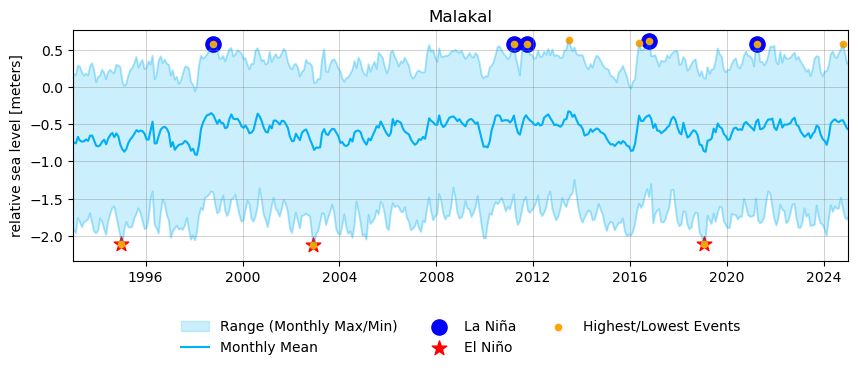

In [ ]:
# static version
top_10_table = get_top_10_table(rsl,uhslc_id)
# get top_10_table for each record
fig,ax = plt.subplots(1,1,figsize=(10,3))

x = rsl_monthly_mean.time - np.timedelta64(15,'D') # add 15 days to make the line in the middle of the month

# station_name = str(rsl_subset['station_name'].sel(station_id=station_id).values)
ax.set_title(station_name)
ax.set_ylabel(f'{rsl["sea_level"].attrs["long_name"]} [{rsl["sea_level"].attrs["units"]}]')

# Plot the max, min, and mean lines
# Plot the max, min, and mean lines
ax.plot(x, rsl_monthly_max['sea_level'].sel(record_id=uhslc_id), color=(0/255, 176/255, 246/255, 0.2))
ax.plot(x, rsl_monthly_min['sea_level'].sel(record_id=uhslc_id), color=(0/255, 176/255, 246/255, 0.2))
ax.fill_between(x, rsl_monthly_max['sea_level'].sel(record_id=uhslc_id), 
                 rsl_monthly_min['sea_level'].sel(record_id=uhslc_id), color=(0/255, 176/255, 246/255, 0.2), label='Range (Monthly Max/Min)')
ax.plot(x, rsl_monthly_mean['sea_level'].sel(record_id=uhslc_id), color=(0/255, 176/255, 246/255, 1), label='Monthly Mean')
# Plot the markers for La Niña, El Niño, and other events
ax.scatter(top_10_table[top_10_table['ONI Mode']=='La Nina'].date, top_10_table[top_10_table['ONI Mode']=='La Nina']['sea level (m)'], color='blue', s=120, label='La Niña', marker='o')
ax.scatter(top_10_table[top_10_table['ONI Mode']=='El Nino'].date, top_10_table[top_10_table['ONI Mode']=='El Nino']['sea level (m)'], color='red', s=120, label='El Niño', marker='*')
ax.scatter(top_10_table.date, top_10_table['sea level (m)'], color='orange', s=20, label='Highest/Lowest Events', marker='o')
    
# Setting the x-axis limits
ax.set_xlim(pd.Timestamp('1993-01-01'), pd.Timestamp('2024-12-31'))

# Improve the appearance
ax.grid(True, color='gray', alpha=0.5 ,linewidth=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False, fontsize=10)


# Save the plot to a file
figname = 'SL_rankings_' + station_name.replace(' ', '_') + '.png'
fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')


glue("SL_rankings",fig,display=False)

```{glue:figure} SL_rankings
:name: "SL_rankings"

This is a static version of the previous figure, which can be used for print (or static websites).
```


## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```